# **Loan Approval Project (Part 2)**
## Table of Content
1. Introduction
2. Data Understanding
3. Data Preparation
4. Modeling & Evaluation

# 3.0 Data Preparation

**Environment Setup**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, matthews_corrcoef

df = pd.read_csv('lending_club_loan_dataset.csv')

# Print dataframe head and info
display(df.head())
display(df.info())

,id,grade,annual_inc,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
0,11454641,A,100000.0,1,1,RENT,26.27,credit_card,36 months,1,NaN,43.2,0.0,0.160624,0
1,9604874,A,83000.0,0,4,OWN,5.39,credit_card,36 months,0,NaN,21.5,0.0,0.810777,0
2,9684700,D,78000.0,0,11,MORTGAGE,18.45,debt_consolidation,60 months,1,NaN,46.3,0.0,0.035147,1
3,9695736,D,37536.0,0,6,MORTGAGE,12.28,medical,60 months,0,NaN,10.7,0.0,0.534887,1
4,9795013,D,65000.0,0,11,MORTGAGE,11.26,debt_consolidation,36 months,0,NaN,15.2,0.0,0.166500,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     20000 non-null  int64  
 1   grade                  20000 non-null  object 
 2   annual_inc             20000 non-null  float64
 3   short_emp              20000 non-null  int64  
 4   emp_length_num         20000 non-null  int64  
 5   home_ownership         18509 non-null  object 
 6   dti                    19846 non-null  float64
 7   purpose                20000 non-null  object 
 8   term                   20000 non-null  object 
 9   last_delinq_none       20000 non-null  int64  
 10  last_major_derog_none  574 non-null    float64
 11  revol_util             20000 non-null  float64
 12  total_rec_late_fee     20000 non-null  float64
 13  od_ratio               20000 non-null  float64
 14  bad_loan               20000 non-null  int64  
dtypes:

None

## 3.1 Data Selection

### 3.1.1 ID

ID contains unique values for each individual. Since it is redundant as there is no relation to the target variable, we will drop this feature.

In [2]:
# Remove 'id' feature
df.drop('id', axis=1, inplace=True)

### 3.1.2 Bad Rating

Bad Rating has too many missing values, hence it is hard to fill these missing values through any means.

In [3]:
# Remove 'last_major_derog_none' feature
df.drop('last_major_derog_none', axis=1, inplace=True)

## 3.2 Data Cleaning

### 3.2.1 Debt-to-Income Ratio

DTI feature contains a small portion of missing values. We will fill the ratio based on the mean DTI of their annual income quartile. This is found by finding the quartile values of annual income, grouping DTI values into the quartile ranges, and finding the mean DTI of each range.

In [4]:
# Find quartiles of 'annual_inc'
df['annual_inc'].describe()

count      20000.000000
mean       73349.578350
std        45198.567255
min         8412.000000
25%        47000.000000
50%        65000.000000
75%        88000.000000
max      1000000.000000
Name: annual_inc, dtype: float64

In [5]:
# Bin 'dti' by 'annual_inc' quartiles
df['annual_inc_bin'] = np.where(df['annual_inc'] <= 47000, '0-25', np.where(
                                df['annual_inc'] <= 65000, '25-50', np.where(
                                df['annual_inc'] <= 88000, '50-75', '75-100')))
df.groupby('annual_inc_bin')['dti'].mean()

annual_inc_bin
0-25      18.352857
25-50     17.537817
50-75     16.423471
75-100    13.893125
Name: dti, dtype: float64

In [6]:
# Fill missing 'dti' values with average DTI values for their income quartile
df['dti'] = np.where((df['annual_inc_bin'] == '0-25') & (df['dti'].isnull()), 18.35, df['dti'])
df['dti'] = np.where((df['annual_inc_bin'] == '25-50') & (df['dti'].isnull()), 17.54, df['dti'])
df['dti'] = np.where((df['annual_inc_bin'] == '50-75') & (df['dti'].isnull()), 16.42, df['dti'])
df['dti'] = np.where((df['annual_inc_bin'] == '75-100') & (df['dti'].isnull()), 13.89, df['dti'])

### 3.2.2 Home Ownership

Home Ownership also contains a handful of missing values. Using our newly created 'annual_inc_bin', we can see from the visualisation below that those belonging to the '0-25' bin are staying in rented homes. Also, '75-100' have their homes mortgaged.

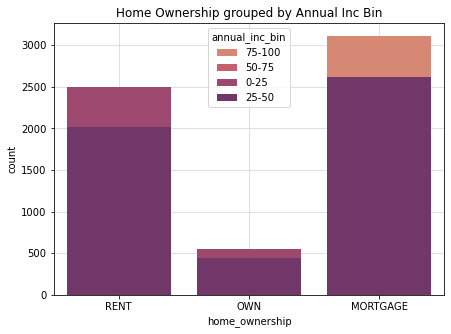

In [7]:
# Plot countplot
plt.figure(figsize=(7,5))
sns.countplot(x='home_ownership', data=df, palette='flare', hue='annual_inc_bin', dodge=False)

# Visual settings
plt.grid(True, axis='both', color='#DAD8D7')
plt.gca().set_axisbelow(True)
plt.title('Home Ownership grouped by Annual Inc Bin')
plt.show()

Using this insight, we will fill the missing values based on whether or not an individual is in the '0-25' bin. Those in this bin will have their missing values filled as RENT, while the others as MORTGAGE, since it is the most common home ownership value.

In [8]:
df['home_ownership'] = np.where((df['annual_inc_bin'] == '0-25') & (df['home_ownership'].isnull()), 'RENT', df['home_ownership'])
df['home_ownership'] = np.where((df['annual_inc_bin'] != '0-25') & (df['home_ownership'].isnull()), 'MORTGAGE', df['home_ownership'])

# Drop temporary column
df.drop('annual_inc_bin', axis=1, inplace=True)

### 3.2.3 Term

Term has inconsistant naming for its values, hence we will correct the error.

In [9]:
# Standardise naming for '36 months' values
df['term'] = np.where(df['term'] == ' 36 Months', ' 36 months', df['term'])

## 3.3 Feature Engineering

### 3.3.1 Grade

Since **'Grade'** is an ordinal feature, we will encode it to a numeric datatype for subsequent modelling.

In [10]:
# Encode alphabetic grades into numbers
df['grade'].replace(['A', 'B', 'C', 'D', 'E', 'F', 'G'], [0, 1, 2, 3, 4, 5, 6], inplace=True)

### 3.3.2 Short Employment and Employment Length

Values from **'short_emp'** are taken directly from **'emp_length_num'** values as **'short_emp'** is a binary feature describing whether an individual has an employment length of more than a year. Hence, we would remove **'short_emp'** as it is already represented.

The value 11 in **'emp_length_num'** may not truly be 11 years due to both the maximum value being 11 for the feature and having an extremely large count. It could be that individuals having more than 11 years of experience are grouped under the value 11, hence the absence of values greater than 11 and it having many records.

We will drop **'short_emp'** and classify employment length as either having 11 or more, or having less than 11 years of employment (1 = 11 or more, 0 = less than 11).

In [11]:
# Remove 'short_emp' feature
df.drop('short_emp', axis=1, inplace=True)

# Rewrite values greater or equal to 11 to '1', the rest to '0'
df['emp_length_num'] = np.where(df['emp_length_num'] >= 11, 1, 0)

# Rename column
df.rename(columns = {'emp_length_num': 'emp_length_11'}, inplace=True)

### 3.3.3 Home Ownership

Home Ownership is a nominal feature, hence we will apply one-hot encoding. We will also drop one of the encoded value to prevent multicollinearity.

In [12]:
# Get dummie features for 'home_ownership', remove the first feature
df = pd.get_dummies(df, columns=['home_ownership'], drop_first=True)

### 3.3.4 Purpose

Similar to Home Ownership, Purpose is also a nominal feature. We will apply the same methods used previously.

In [13]:
# Get dummie features for 'purpose', remove the first feature
df = pd.get_dummies(df, columns=['purpose'], drop_first=True)

### 3.3.5 Term

Term also being a nominal feature would require the same methods used previously.

In [14]:
# Get dummie features for 'term', remove the first feature
df = pd.get_dummies(df, columns=['term'], drop_first=True)

# Rename column
df.rename(columns = {'term_ 60 months': 'term_60 months'}, inplace=True)

## 3.4 Data Transformation

### 3.4.1 Normalisation

We will normalise numerical columns (continuous values) using z-score normalisation to prevent features with larger ranges from affecting subsequent modelling.

In [15]:
# Define standard scaler
scaler = StandardScaler()

# Transform numerical features
df_scaled = pd.DataFrame(scaler.fit_transform(df[{'annual_inc', 'dti', 'revol_util', 'od_ratio'}]), 
                        columns=df[{'annual_inc', 'dti', 'revol_util', 'od_ratio'}].columns)

# Replace old features with transformed features
df_trfm = pd.concat([df.drop({'annual_inc', 'dti', 'revol_util', 'od_ratio'}, axis=1), df_scaled], axis=1)

# Print transformed dataframe and info
display(df_trfm.head())
display(df.info())

,grade,emp_length_11,last_delinq_none,total_rec_late_fee,bad_loan,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,...,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_60 months,dti,revol_util,annual_inc,od_ratio
0,0,0,1,0.0,0,0,1,1,0,0,...,0,0,0,0,0,0,1.281286,-0.302926,0.589645,-1.194963
1,0,0,0,0.0,0,1,0,1,0,0,...,0,0,0,0,0,0,-1.481386,-0.818165,0.213517,1.064764
2,3,1,1,0.0,1,0,0,0,1,0,...,0,0,0,0,0,1,0.246607,-0.229320,0.102891,-1.631081
3,3,0,0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,1,-0.569757,-1.074597,-0.792381,0.105857
4,3,1,0,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,-0.704716,-0.967750,-0.184736,-1.174539


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   grade                       20000 non-null  int64  
 1   annual_inc                  20000 non-null  float64
 2   emp_length_11               20000 non-null  int32  
 3   dti                         20000 non-null  float64
 4   last_delinq_none            20000 non-null  int64  
 5   revol_util                  20000 non-null  float64
 6   total_rec_late_fee          20000 non-null  float64
 7   od_ratio                    20000 non-null  float64
 8   bad_loan                    20000 non-null  int64  
 9   home_ownership_OWN          20000 non-null  uint8  
 10  home_ownership_RENT         20000 non-null  uint8  
 11  purpose_credit_card         20000 non-null  uint8  
 12  purpose_debt_consolidation  20000 non-null  uint8  
 13  purpose_home_improvement    200

None

# 4.0 Modeling

## 4.1 Train-test Split

We will split the data, allocating 70% for training and 30% for testing. We will also stratify the split to ensure both training and testing datasets retain the same class distribution (4:1) for our target variable.

In [16]:
# Load feature and target variables
X = df_trfm.drop('bad_loan', axis=1)
y = df_trfm['bad_loan']

# Split data into training and test: 70% train, stratified split on target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

## 4.2 Model Building

We will use several algorithms to determine which works best with our dataset. We start of by modeling each algorithm to our training dataset using cross validation of 10 folds, followed by scoring each model using accuracy, f1 score, and AUC.

In [17]:
# Initialise a list of algorithms to be evaluated
algorithms = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Support Vector Machine': SVC(probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Trees': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Extreme GB': XGBClassifier()
}

# Initialise table to store results
results = pd.DataFrame(columns=["Algorithm", "Accuracy (%)", "F1 Score (%)", "AUC"])

# Model building
for name, algorithm in algorithms.items():
    # Model evaluation using cross validation (10-folds)
    scores = cross_validate(algorithm, X_train, y_train, cv=10, scoring=["accuracy", "f1", "roc_auc"])
    # Store results into results table
    results = results.append({"Algorithm": name, 
                              "Accuracy (%)": scores["test_accuracy"].mean(), 
                              "F1 Score (%)": scores["test_f1"].mean(), 
                              "AUC": scores["test_roc_auc"].mean()}, ignore_index=True)

## 4.3 Model Evaluation

### 4.3.1 Confusion Matrix Scores

,Algorithm,Accuracy (%),F1 Score (%),AUC,Average
0,Logistic Regression,0.804643,0.134566,0.704241,0.547817
1,Support Vector Machine,0.804643,0.068032,0.610247,0.494307
2,K-Nearest Neighbors,0.777857,0.235181,0.614127,0.542388
3,Decision Trees,0.700571,0.279095,0.546875,0.508847
4,Random Forest,0.799286,0.154124,0.670313,0.541241
5,Gradient Boosting,0.804143,0.135432,0.704878,0.548151
6,Extreme GB,0.791857,0.184118,0.665693,0.547223


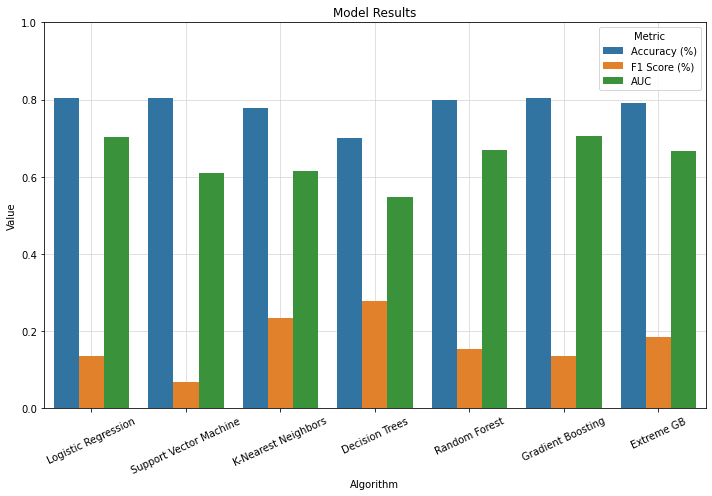

In [18]:
# Calculate average value and display table
results['Average'] = results[['Accuracy (%)', 'F1 Score (%)', 'AUC']].mean(axis=1)
display(results)

# Reshape data
results_long = pd.melt(results, id_vars='Algorithm', value_vars=['Accuracy (%)', 'F1 Score (%)', 'AUC'], value_name='Value')
results_long = results_long.rename(columns={'variable': 'Metric'})

# Plot barplot
plt.figure(figsize=(10,7))
sns.barplot(x='Algorithm', y='Value', hue='Metric', data=results_long)

# Visual settings
plt.ylim(0,1)
plt.xticks(rotation=25)
plt.grid(True, axis='both', color='#DAD8D7')
plt.gca().set_axisbelow(True)
plt.title('Model Results')
plt.tight_layout()
plt.show()

The results show Logistic Regression and Support Vector Machine performing the best for accuracy (80.5%), Decision Trees for F1 Score (28.0%), and Gradient Boosting for Area Under Curve (70.5%). Overall, Extreme GB performed the best if we were to take the average values of the three metrics. However, since there is a huge class imbalance for our target variable, we will look at other evaluation metrics to find the best algorithm.

### 4.3.2 Receiver Operating Characteristic Curve

,Algorithm,AUC
5,Gradient Boosting,0.704878
0,Logistic Regression,0.704241
4,Random Forest,0.670313
6,Extreme GB,0.665693
2,K-Nearest Neighbors,0.614127
1,Support Vector Machine,0.610247
3,Decision Trees,0.546875


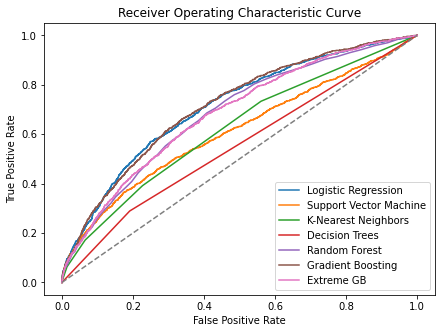

In [19]:
# Display AUC values
display(results[['Algorithm','AUC']].sort_values(by='AUC', ascending=False))

# Create plot
plt.figure(figsize=(7,5))

# Loop through each algorithm
for name, algorithm in algorithms.items():
    # Calculate predicted probability
    y_pred_proba = algorithm.fit(X_train, y_train).predict_proba(X_test)[:,1]
    # Calculate false and true positive rate
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    # Plot values
    plt.plot(fpr, tpr, label=name)

# Visual settings
plt.title('Receiver Operating Characteristic Curve')
plt.plot([0, 1], [0, 1],'--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Gradient boosting performs the best when using Area-Under-Curve (AUC) to score. It is worth noting that the AUC for Gradient boosting and Linear Regression are almost identical to Gradient Boosting, differing by a small amount.

From the Receiver Operating Characteristic (ROC) visual, we can see how well each algorithm has performed at various threshold settings, with the best having an ROC curve plotted closer to the top left corner. Gradient boosting and Linear Regression can be seen performing the best and overlapping each other on the visual, hence explaining their similar AUC values.

### 4.3.3 Matthews Correlation Coefficient

In [20]:
# Initialise table
matt_coeff = pd.DataFrame(columns=["Algorithm", "Matt Coeff"])

# Loop through each algorithm
for name, algorithm in algorithms.items():
    # Train a model
    model = algorithm.fit(X_train, y_train)
    # Store the model's predictions
    y_pred = model.predict(X_test)
    # Measure MCC and store into table
    matt_coeff_value = matthews_corrcoef(y_test, y_pred)
    matt_coeff = matt_coeff.append({"Algorithm": name, 
                                    "Matt Coeff": matt_coeff_value}, ignore_index=True)
    
# Display table, descending MCC
matt_coeff.sort_values(by='Matt Coeff', ascending=False)

,Algorithm,Matt Coeff
5,Gradient Boosting,0.177060
0,Logistic Regression,0.176599
4,Random Forest,0.169894
6,Extreme GB,0.164424
2,K-Nearest Neighbors,0.151060
1,Support Vector Machine,0.131029
3,Decision Trees,0.086209


Using Matthews Correlation Coefficient (MCC), we can derive that Gradient Boosting performs the best. Since MCC is considered a better evaluation metric than ROC or F1 scores in imbalanced binary classification datasets, we will conclude that Gradient Boosting is the best algorithm for our dataset.

## 4.4 Model Tuning

We will use a dictonary of hyperparemeters and their possible values to retrieve the best hyperparemeters found by the grid search for the Gradient Boosting algorithm.

In [21]:
# Initialise algorithm
gb = GradientBoostingClassifier()

# Define hyperparameters and their possible values
parameters = {
    "learning_rate": [0.01, 0.005, 0.001],
    "n_estimators": [500, 750, 1000],
    "min_samples_leaf": [25, 50, 100]
}

# Initialise and train GridSearchCV model
gb_clf = GridSearchCV(gb, parameters, cv=10)
gb_clf.fit(X_train, y_train)

# Print best hyperparameters found by GridSearchCV
print("Best hyperparameters:", gb_clf.best_params_)

Best hyperparameters: {'learning_rate': 0.005, 'min_samples_leaf': 50, 'n_estimators': 750}


## 4.5 Evaluation

**Confusion Matrix**

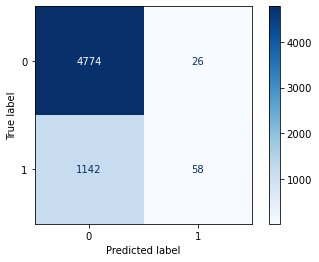

In [22]:
# Plot confusion matrix
plot_confusion_matrix(gb_clf, X_test, y_test, values_format=".4g", cmap="Blues");

**Classification Report**

In [23]:
# Test model and print results
y_pred = gb_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89      4800
           1       0.69      0.05      0.09      1200

    accuracy                           0.81      6000
   macro avg       0.75      0.52      0.49      6000
weighted avg       0.78      0.81      0.73      6000



**Results:**
- True Positive (TP): 4774 - Model correctly identified 4774 non-defaulters.


- True Negative (TN): 58 - Model correctly identified 58 defaulters.


- False Positive (FP): 1142 - Model incorrectly identified 1142 defaulters as non-defaulters.


- False Negative (FN): 26 - Model incorrectly identified 26 non-defaulters as defaulters.

**Class 0 (Non-defaulters):**
- Precision: 0.81 - 81% of non-defaulters were indeed non-defaulters.


- Recall: 0.99 - 99% of non-defaulter were identified.

**Class 1 (Defaulters):**
- Precision: 0.69 - 69% of defaulters were indeed defaulters.


- Recall: 0.05 - 5% of defaulters were identified.

**Model performs well when identifying individuals who are non-defaulters, but performs poorly when identifying defaulters.**